In [68]:
import sqlite3
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np
import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC , SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix , roc_auc_score, roc_curve
from imblearn.over_sampling import ADASYN, SMOTE
from collections import Counter
%matplotlib inline

#### Reading the dataframe pickled in previous notebook after cleaning and EDA

In [2]:
fire_clean_model_df = pd.read_pickle("./fire_clean_model.pkl")

In [3]:
fire_clean_model_df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,CAUSE_LABEL,AK,AL,AR,AZ,CA,CO,...,VT,WA,WI,WV,WY,DAYS_TO_CONT,fall,spring,summer,winter
1,2004,133,0.25,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,2004,152,0.10,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,2004,180,0.10,0,0,0,0,0,1,0,...,0,0,0,0,0,5,0,0,1,0
4,2004,180,0.10,0,0,0,0,0,1,0,...,0,0,0,0,0,5,0,0,1,0
5,2004,182,0.10,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [4]:
fire_clean_model_df.columns

Index(['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'CAUSE_LABEL', 'AK', 'AL',
       'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY', 'DAYS_TO_CONT', 'fall', 'spring', 'summer', 'winter'],
      dtype='object')

#### Create X & Y subsets from dataframe

In [5]:
X = fire_clean_model_df.drop(['CAUSE_LABEL','FIRE_YEAR'],
                            axis = 1)

In [6]:
Y = fire_clean_model_df['CAUSE_LABEL']

In [8]:
# X.columns

#### Class Imbalance Handling - ADASYN

In [11]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X,Y)

In [14]:
Counter(y_adasyn)

Counter({0: 1116838, 1: 1111308})

#### Class Imbalance Handling - SMOTE

SMOTE gives better results than ADASYN

In [94]:
X_smote, y_smote = SMOTE(sampling_strategy=0.5).fit_sample(X,Y)

In [95]:
Counter(y_smote)

Counter({0: 555654, 1: 1111308})

#### Creating Train Test Validate Subsets

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_adasyn, y_adasyn, test_size=0.2, stratify = y_adasyn)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, stratify = y_train_val)

In [96]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify = y_smote)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, stratify = y_train_val)

#### Initial Logistic Regression

In [97]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_val, y_val)))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score for logistic regression is
Training:  84.15%
Test set:  84.19%


In [98]:
y_predict = logit.predict(X_val)
precision_score(y_val, y_predict), recall_score(y_val, y_predict)

(0.8729438781570461, 0.8927661948511216)

In [99]:
# plt.figure(figsize=(16,5))
logit.predict_proba(X_val)
# hist of class 1 probas

array([[0.06627534, 0.93372466],
       [0.01298268, 0.98701732],
       [0.91062081, 0.08937919],
       ...,
       [0.01548893, 0.98451107],
       [0.52789345, 0.47210655],
       [0.25646772, 0.74353228]])

In [100]:
print("Logistic confusion matrix: \n\n", confusion_matrix(y_val, logit.predict(X_val)))

Logistic confusion matrix: 

 [[ 82250  28881]
 [ 23834 198428]]


In [ ]:
# for item in zip(X.columns, logit.coef_[0]):
#     print(item)

In [ ]:
print(logit.coef_[0].shape)

#### Initial Naive Bayes

In [103]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_val, y_val)

0.8314271745357581

In [104]:
y_predict = nb.predict(X_val)
precision_score(y_val, y_predict), recall_score(y_val, y_predict)

(0.9142887080437289, 0.8244279274009952)

In [105]:
print("GaussianNB confusion matrix: \n\n", confusion_matrix(y_val, nb.predict(X_val)))

GaussianNB confusion matrix: 

 [[ 93953  17178]
 [ 39023 183239]]


In [106]:
nb_B = BernoulliNB()
nb_B.fit(X_train,y_train)
nb_B.score(X_val,y_val)

0.8235895774656337

In [107]:
y_predict = nb_B.predict(X_val)
precision_score(y_val, y_predict), recall_score(y_val, y_predict)

(0.8810758384004178, 0.8501318264030738)

In [108]:
print("BernoulliNB confusion matrix: \n\n", confusion_matrix(y_val, nb_B.predict(X_val)))

BernoulliNB confusion matrix: 

 [[ 85627  25504]
 [ 33310 188952]]


#### Initial Decision Tree

In [101]:
decisiontree = DecisionTreeClassifier(max_depth=4)


decisiontree.fit(X_train, y_train)
decisiontree.score(X_val, y_val)

y_predict = decisiontree.predict(X_val)

print(precision_score(y_val, y_predict), recall_score(y_val, y_predict))

print("\n Decision confusion matrix: \n\n", confusion_matrix(y_val, decisiontree.predict(X_val)))

0.8357449461441576 0.8926402174010852

 Decision confusion matrix: 

 [[ 72138  38993]
 [ 23862 198400]]


#### Initial RandomForest

In [102]:
randomforest = RandomForestClassifier(n_estimators=100, max_depth=3)


randomforest.fit(X_train, y_train)
randomforest.score(X_val, y_val)

y_predict = randomforest.predict(X_val)

print(precision_score(y_val, y_predict), recall_score(y_val, y_predict))

print("\n Random Forest confusion matrix: \n\n", confusion_matrix(y_val, randomforest.predict(X_val)))

0.8172676906876842 0.9218759841988284

 Random Forest confusion matrix: 

 [[ 65318  45813]
 [ 17364 204898]]


ROC AUC score =  0.8942644740559099


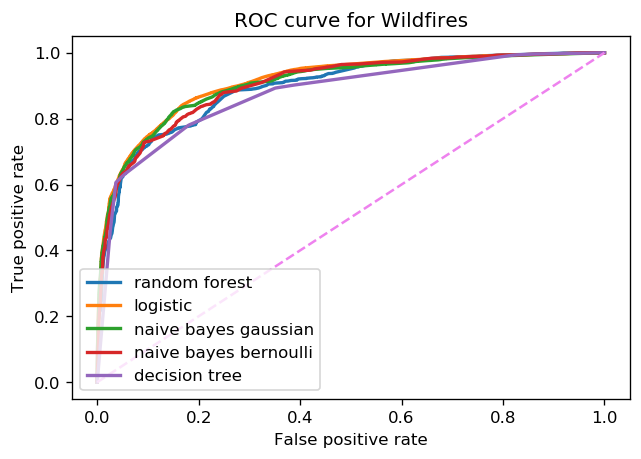

In [109]:
fpr, tpr, thresholds = roc_curve(y_val, randomforest.predict_proba(X_val)[:,1])
fpr_l, tpr_l, thresholds_l = roc_curve(y_val, logit.predict_proba(X_val)[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, nb.predict_proba(X_val)[:,1])
fpr_nbb, tpr_nbb, thresholds_nbb = roc_curve(y_val, nb_B.predict_proba(X_val)[:,1])
fpr_d, tpr_d, thresholds_d = roc_curve(y_val, decisiontree.predict_proba(X_val)[:,1])

plt.figure(dpi=120)
plt.plot(fpr, tpr,lw=2, label = 'random forest')
plt.plot(fpr_l, tpr_l,lw=2, label = 'logistic')
plt.plot(fpr_nb, tpr_nb,lw=2, label = 'naive bayes gaussian')
plt.plot(fpr_nbb, tpr_nbb,lw=2, label = 'naive bayes bernoulli')
plt.plot(fpr_d, tpr_d,lw=2, label = 'decision tree')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc = 'lower left')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Wildfires');
print("ROC AUC score = ", roc_auc_score(y_val, randomforest.predict_proba(X_val)[:,1]))

#### Class Imbalance Handling - Under Sampling

In [71]:
from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X,Y)

In [72]:
Counter(y_under)

Counter({0: 278390, 1: 278390})

In [88]:
X_train_val_u, X_test_u, y_train_val_u, y_test_u = train_test_split(X_under, y_under, test_size=0.2, stratify = y_under)
X_train_u, X_val_u, y_train_u, y_val_u = train_test_split(X_train_val_u, y_train_val_u, test_size=.25, stratify = y_train_val_u)

In [91]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train_u, y_train_u)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit.score(X_train_u, y_train_u)))
print("Test set: {:6.2f}%".format(100*logit.score(X_val_u, y_val_u)))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score for logistic regression is
Training:  82.88%
Test set:  82.49%


In [92]:
y_predict_u = logit.predict(X_val_u)
print(precision_score(y_val_u, y_predict_u), recall_score(y_val_u, y_predict_u))
print("Logistic confusion matrix: \n\n", confusion_matrix(y_val_u, logit.predict(X_val_u)))

0.8366830430251601 0.8075002694062287
Logistic confusion matrix: 

 [[46902  8776]
 [10718 44960]]


In [93]:
randomforest = RandomForestClassifier(n_estimators=100, max_depth=3)


randomforest.fit(X_train_u, y_train_u)
randomforest.score(X_val_u, y_val_u)

y_predict_u = randomforest.predict(X_val_u)

print(precision_score(y_val_u, y_predict_u), recall_score(y_val_u, y_predict_u))

print("\n Random Forest confusion matrix: \n\n", confusion_matrix(y_val_u, randomforest.predict(X_val_u)))

0.8063943493534644 0.7750817198893638

 Random Forest confusion matrix: 

 [[45317 10361]
 [12523 43155]]
